# Code for More Resource Efficient Model Inference with Quantization (3)

This tutorial shows how to improve model Resource inference efficiency using quantization with PyTorch Lightning - in this first part, we convert code from PyTorch to Lightning and train a baseline.

Author: *Thomas Viehmann*


See the our series of blog posts: [Part 1](https://devblog.pytorchlightning.ai/training-an-edge-optimized-speech-recognition-model-with-pytorch-lightning-a0a6a0c2a413), [Part 2](https://devblog.pytorchlightning.ai/how-to-train-edge-optimized-speech-recognition-models-with-pytorch-lightning-part-2-quantization-2eaa676b1512), Part 3.

This notebook contains both the code for Part 1 and Part 3 (Part 2 is all theory).

The model and training hyperparameters are adapted from the [Speech Command Recognition with TorchAudio](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html) tutorial on the PyTorch web site.

This notebook can be run either in Grid.ai (using the free credits you get at signup, see below), in Colab or on your own (GPU-enabled) computer.

## Training on Grid.ai

Here is how to run this notebook on [Grid.AI](https://grid.ai/) with ease.

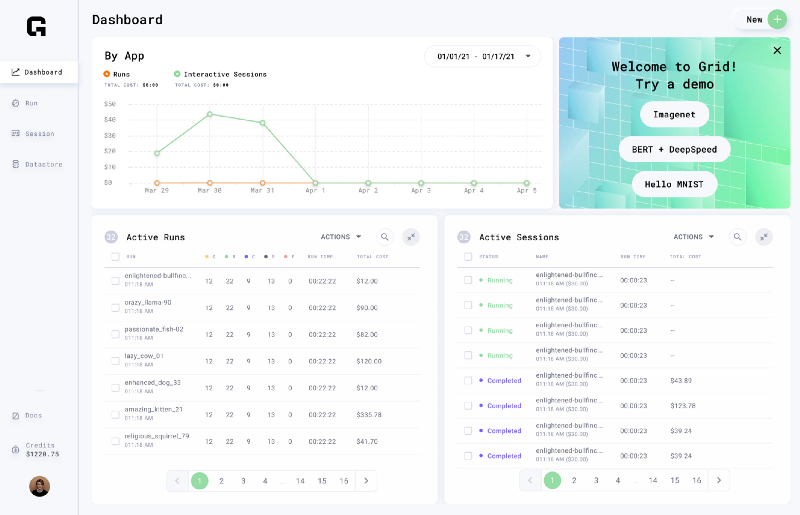

[Grid.AI](https://grid.ai/) enables you to scale training from your laptop to the cloud without having to modify a single line of code. While Grid supports all the classic Machine Learning Frameworks such as TensorFlow, Keras, PyTorch, and more. Leveraging Lightning features such as Early Stopping, Integrated Logging, Automatic Checkpointing, and CLI enables you to make the traditional MLOps behind model training seem invisible.

You can run this relatively quickly on a T4 GPU (~ 1 minute per epoch, so about twice as fast as a free K80 on colab) in Grid.ai.

1. After signing up, you get a \\$25 credit. The single T4 instance (g4dn.xlarge) costs \\$0.55 per hour, so we get around 45 hours of session compute for free.

2. Create a datastore from the speech commands dataset, e.g. using
  ```
  grid datastore create --source https://storage.googleapis.com/download.tensorflow.org/data/speech_commands_v0.02.tar.gz --name speech-commands-v2
  ```
  from the command line.

3. Create a g4dn.xlarge session with the datastore and open the JupyterLab on it. Upload the notebook and run it (increase the number of epochs to 40 if you want reasonable accuracy, one epoch with validation needs about 1.5 minutes). The notebook is a tweak to symlink the datastore to where PyTorch expects the data.
4. Download the resulting .pt files from JupyterLab before pausing the session again.
5. The g4dn.xlarge instance with a single T4 costs \\$0.55 per hour, so if you run both unquantized and quantized training for 40 epochs and remember to pause the instance not too long after training you can run all this in less than \\$1 of your free \\$25 of credits.

## But now the code!

We start with a few preparations:

In [2]:
%matplotlib inline

# Don't forget to turn on the GPU on google colab! Uncomment these for colab.
#!pip install --upgrade pydub torch torchvision torchaudio torchtext 
!pip install pytorch_lightning

!pip install torchaudio

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 922 kB 2.0 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 2.1 MB/s  eta 0:00:01
     |████████████████████████████████| 282 kB 19.4 MB/s eta 0:00:01
Defaulting to user installation because normal site-packages is not writeable
  Using cached torchaudio-0.9.0-cp38-cp38-manylinux1_x86_64.whl (1.9 MB)


In [1]:
from typing import Union, Optional
from pathlib import Path
import torch
import sys
import os
import torchaudio
import pytorch_lightning as pl
from matplotlib import pyplot
import IPython

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Be sure that it says `cuda` above.

Because the Grid.ai datastore from the tar.gz does not quite have the baroque directory structure TorchAudio expects, we create a `data` directory and symlink the datastore.

In [2]:
# if os.path.exists('./speech-commands-v2') and not os.path.exists('data/SpeechCommands/speech_commands_v0.02'):
#    os.mkdirs('data/SpeechCommands', exists_ok=True)
#    os.symlink('../../speech-commands-v2', 'data/SpeechCommands/speech_commands_v0.02', target_is_directory=True)

And now here is the LightningDataModule. It is pretty straightforward. Note the special trick of doing the resampling in the collate function.

In [3]:
class DataModule(pl.LightningDataModule):
    def __init__(
        self,
        dl_path: Union[str, Path] = "data",
        device: Union[torch.device, str, None] = None,
        num_workers: Optional[int] = None,
        pin_memory: Optional[bool] = None,
        batch_size: int = 128,
        sample_rate = 8000,
        
    ):
        super().__init__()

        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        elif isinstance(device, torch.device):
            self.device = device
        else:
            self.device = torch.device(device)

        self._dl_path = dl_path
        self._num_workers = num_workers
        self._batch_size = batch_size
        
        if pin_memory is not None:
            self._pin_memory = pin_memory
        else:
            self._pin_memory = (self.device.type == "cuda")

        if num_workers is not None:
            self._num_workers = num_workers
        else:
            self._num_workers = 16 if self.device.type == "cuda" else 0       
        self._train_dataset = None
        self._val_dataset = None
        self._labels = None
        self._label_to_index = None
        self.sample_rate = sample_rate
        self._transform = None
        self._input_sample_rate = None

    @staticmethod
    def pad_sequence(batch):
        # Make all tensor in a batch the same length by padding with zeros
        batch = [item.t() for item in batch]
        batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
        return batch.permute(0, 2, 1)

    def transform(self, input, input_sample_rate=None):
        if input_sample_rate is None:
            if self._input_sample_rate is None:
                _, self._input_sample_rate, *_ = self.train_dataset[0]
            input_sample_rate = self._input_sample_rate
        # in TorchAudio master (0.9) there is a functional.resample
        return torchaudio.transforms.Resample(orig_freq=input_sample_rate, new_freq=self.sample_rate)(input)

    def collate_fn(self, batch):

        # A data tuple has the form:
        # waveform, sample_rate, label, speaker_id, utterance_number

        tensors, targets = [], []

        # Gather in lists, and encode labels as indices
        for waveform, input_sample_rate, label, *_ in batch:
            
            tensors += [self.transform(waveform, input_sample_rate)]
            targets += [self.label_to_index(label)]

        # Group the list of tensors into a batched tensor
        tensors = self.pad_sequence(tensors)
        targets = torch.stack(targets)
        self._label_to_index = None

        return tensors, targets

    def prepare_data(self, download=False):
        """Download waveforms and prepare dataset."""
        os.makedirs(self._dl_path, exist_ok=True)
        # we don't use the dataset, but download here
        torchaudio.datasets.speechcommands.SPEECHCOMMANDS(root=self._dl_path, download=download)

    @property
    def data_path(self):
        return Path(self._dl_path).joinpath("speech_commands")

    def __dataset(self, train: bool):
        return torchaudio.datasets.speechcommands.SPEECHCOMMANDS(root=self._dl_path,
                                                        subset="training" if train else "validation")

    @property
    def labels(self):
        if self._labels is None:
            self._labels = sorted({os.path.basename(os.path.dirname(p)) for p in self.train_dataset._walker})
        return self._labels

    @property
    def train_dataset(self):
        # note that we don't do any augmentation (randomness) here, so caching is OK
        if self._train_dataset is None:
            self._train_dataset = self.__dataset(train=True)
        return self._train_dataset

    @property
    def val_dataset(self):
        if self._val_dataset is None:
            self._val_dataset = self.__dataset(train=False)
        return self._train_dataset

    def __dataloader(self, train: bool):
        """Train/validation loaders."""
        return torch.utils.data.DataLoader(
            self.train_dataset if train else self.val_dataset,
            batch_size=self._batch_size,
            shuffle=train,
            drop_last=train,
            collate_fn=self.collate_fn,
            pin_memory=self._pin_memory,
            num_workers=self._num_workers,
        )
    
    def train_dataloader(self):
        return self.__dataloader(train=True)

    def val_dataloader(self):
        return self.__dataloader(train=False)

    def label_to_index(self, word):
        if self._label_to_index is None:
            self._label_to_index = {l: torch.tensor(idx) for idx, l in enumerate(self.labels)}
        # Return the position of the word in labels, slow...
        return self._label_to_index[word]

    def index_to_label(self, index):
        # Return the word corresponding to the index in labels
        # This is the inverse of label_to_index
        return self.labels[index]


In [4]:
dm = DataModule(dl_path='data', num_workers=4)
try:
    dm.prepare_data(download=True)
except:
    os.remove("data/speech_commands_v0.02.tar.gz")
    raise

  0%|          | 0.00/2.26G [00:00<?, ?B/s]

We can visualize the data (coming from the dataset instead of the dataloader, this is before resampling):

Shape of waveform: torch.Size([1, 16000])
Sample rate of waveform: 16000


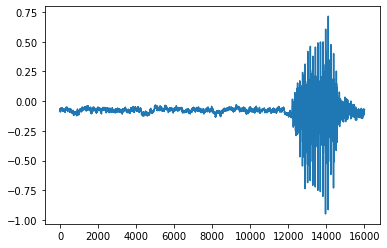

In [5]:
waveform, sample_rate, label, speaker_id, utterance_number = dm.train_dataset[0]

print("Shape of waveform: {}".format(waveform.size()))
print("Sample rate of waveform: {}".format(sample_rate))

pyplot.plot(waveform.t().numpy());

Let’s find the list of labels available in the dataset.




The 35 audio labels are commands that are said by users. The first few
files are people saying “backward”.




In [6]:
waveform_first, *_ = dm.train_dataset[0]
IPython.display.Audio(waveform_first.numpy(), rate=sample_rate)


The last file is someone saying “zero”.




In [7]:
waveform_last, *_ = dm.train_dataset[-1]
IPython.display.Audio(waveform_last.numpy(), rate=sample_rate)

## The model

This directly mirrors [the model in the tutorial](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html#define-the-network), but I find the `nn.Sequential` more elegant here (and it will be useful to us, later, too).

In [8]:
class M5(torch.nn.Sequential):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__(
            torch.nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride),
            torch.nn.BatchNorm1d(n_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(4),
            torch.nn.Conv1d(n_channel, n_channel, kernel_size=3),
            torch.nn.BatchNorm1d(n_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(4),
            torch.nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3),
            torch.nn.BatchNorm1d(2 * n_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(4),
            torch.nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3),
            torch.nn.BatchNorm1d(2 * n_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool1d(4),
            torch.nn.AdaptiveAvgPool1d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(2 * n_channel, n_output),
        )


But we not only need a PyTorch module but also a Lightning module. This is pretty vanilla PyTorch lightning tooling, we use the optimization hyperparameters from the tutorial except that I halved the learning rate after Quantization Aware Training ran into NaNs below. Personally, I like to do my LightningModule as a wrapper, but any other way is OK, too.


In [9]:
class AudioModel(pl.LightningModule):
    def __init__(self, klass=M5):
        # n_input = 1 for mono, 2 for stereo
        super().__init__()
        self.model = klass(n_input=1, n_output=len(dm.labels))
        self.val_accuracy = pl.metrics.Accuracy()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inp, label = batch
        pred = self(inp)
        loss = torch.nn.functional.cross_entropy(pred, label)
        # Logging to TensorBoard by default
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        inp, label = batch
        pred = self(inp)
        loss = torch.nn.functional.cross_entropy(pred, label)        
        acc = self.val_accuracy(pred.softmax(dim=-1), label)
        self.log('valid_acc', acc, on_step=True, on_epoch=True)
        self.log('valid_loss',loss, on_step=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        opt = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=0.0001)
        sched = torch.optim.lr_scheduler.StepLR(opt, step_size=20, gamma=0.1) 
        return [opt], [sched]



## Training the baseline floating-boint model

Datamodule, model and we're good to go!
(You can safely skip this, too, if you are only interested in the quantized version!)

In [11]:
model = AudioModel()
trainer = pl.Trainer(gpus=0, max_epochs=2, check_val_every_n_epoch=1)  # for real training, I use 40 epochs or so
trainer.fit(model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

  | Name         | Type     | Params
------------------------------------------
0 | model        | M5       | 26.9 K
1 | val_accuracy | Accuracy | 0     
------------------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.108     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

/home/silversurfer42/fun/quant/qq/lib/python3.8/site-packages/torch/nn/functional.py:652: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool1d(input, kernel_size, stride, padding, dilation, ceil_mode)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Let's see how we are doing! If you ran 40 epochs, this should give 85%-ish accuracy, 2 epochs on colab only 70%-ish.

In [13]:
model.val_accuracy.compute()

tensor(0.7016)

Now we save the model to TorchScript.

In [14]:
torch.jit.save(model.to_torchscript(), 'audio_model_fp32.pt')

/home/silversurfer42/fun/quant/qq/lib/python3.8/site-packages/torch/jit/_recursive.py:575: LightningDeprecationWarning: The `LightningModule.datamodule` property is deprecated in v1.3 and will be removed in v1.5. Access the datamodule through using `self.trainer.datamodule` instead.
  item = getattr(mod, name, None)
/home/silversurfer42/fun/quant/qq/lib/python3.8/site-packages/torch/jit/_recursive.py:575: LightningDeprecationWarning: The `LightningModule.loaded_optimizer_states_dict` property is deprecated in v1.4 and will be removed in v1.6.
  item = getattr(mod, name, None)


# The quantized model

This is the what is discussed in Part 3.

As mentioned, in the blog post, the QNNPACK backend does not support 1d (at the time of writing).
So here is the 1d-disguised-as-2d model.


In [16]:
class M5_2d(torch.nn.Sequential):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__(
            torch.nn.Unflatten(1, (1, 1)),
            torch.nn.Conv2d(n_input, n_channel, kernel_size=(1, 80), stride=(1, stride)),
            torch.nn.BatchNorm2d(n_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((1, 4)),
            torch.nn.Conv2d(n_channel, n_channel, kernel_size=(1, 3)),
            torch.nn.BatchNorm2d(n_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((1, 4)),
            torch.nn.Conv2d(n_channel, 2 * n_channel, kernel_size=(1, 3)),
            torch.nn.BatchNorm2d(2 * n_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((1, 4)),
            torch.nn.Conv2d(2 * n_channel, 2 * n_channel, kernel_size=(1, 3)),
            torch.nn.BatchNorm2d(2 * n_channel),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d((1, 4)),
            torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(2 * n_channel, n_output),
        )

model = AudioModel(M5_2d)

Next, we want to identify fusion opportunities. We create a list of Conv2d-BatchNorm2d-ReLU sequences to pass to the Lightning Quantization callback.

In [17]:
layers_to_fuse = []
for i in range(len(model.model) - 2):
    if (isinstance(model.model[i], torch.nn.Conv2d) and
        isinstance(model.model[i + 1], torch.nn.BatchNorm2d) and
        isinstance(model.model[i + 2], torch.nn.ReLU)):
        layers_to_fuse.append([f'model.{ii}' for ii in [i, i + 1, i + 2]])

layers_to_fuse

[['model.1', 'model.2', 'model.3'],
 ['model.5', 'model.6', 'model.7'],
 ['model.9', 'model.10', 'model.11'],
 ['model.13', 'model.14', 'model.15']]

Now we are ready to run the Quantization Aware Training. We use the Lightning Callback that does most of the magic.
Under the hood:
- It configures the targeted backend (QNNPACK),
- fuses the layers,
- runs Quantization Aware Training,
- and converts the model at the end of the training.

Note that the latter means that it is harder to resume training because the trainable model we start with is converted into a (fixed) quantized model.

In [19]:
from pytorch_lightning.callbacks import QuantizationAwareTraining
model = AudioModel(M5_2d)
# for real training, I use 40 epochs or so instead of just 2
trainer = pl.Trainer(gpus=0, max_epochs=1, check_val_every_n_epoch=1, callbacks=[
    QuantizationAwareTraining(qconfig='fbgemm', modules_to_fuse=layers_to_fuse)])
trainer.fit(model, datamodule=dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/silversurfer42/fun/quant/qq/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
/home/silversurfer42/fun/quant/qq/lib/python3.8/site-packages/torch/quantization/observer.py:122: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(

  | Name         | Type        | Params
---------------------------------------------
0 | model        | M5_2d       | 26.9 K
1 | val_accuracy | Accuracy    | 0     
2 | quant        | QuantStub   | 0     
3 | dequant      | DeQuantStub | 0     
---------------------------------------------
26.9 K    Trai

Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/silversurfer42/fun/quant/qq/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


As a quick check, we can compute the validation accuracy. But note that the validation is done on the pseudo-quantized model, not the final quantized model.

In [20]:
model.val_accuracy.compute()

tensor(0.6612)

Looks OK, let's save to TorchScript.

In [21]:
smodel = model.to_torchscript()
torch.jit.save(smodel, 'audio_model_quantized.pt')

In [23]:
smodel.dequant(smodel(smodel.quant(torch.randn(1, 1, 8000))))

tensor([[-4.2631, -1.4210, -0.2842,  0.2842, -0.2842,  1.9894, -3.1263,  0.5684,
         -2.8421, -3.6947,  1.1368, -0.5684, -5.6841, -1.1368, -2.5579, -1.9894,
         -4.5473, -0.2842, -1.4210, -0.8526,  0.0000, -3.4105, -3.4105, -2.8421,
         -2.5579, -1.7052, -0.8526, -1.1368, -2.8421, -0.5684, -2.5579, -5.3999,
         -1.4210, -3.6947, -2.2737]])

In [24]:
trainer.validate(model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Validating: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'valid_acc': 0.6639793515205383,
 'valid_acc_epoch': 0.6639793515205383,
 'valid_loss': 1.1305274963378906,
 'valid_loss_epoch': 1.1305274963378906}
--------------------------------------------------------------------------------


[{'valid_acc': 0.6639793515205383,
  'valid_acc_epoch': 0.6639793515205383,
  'valid_loss': 1.1305274963378906,
  'valid_loss_epoch': 1.1305274963378906}]

So our quantized model is reasonably accurate, we exported it to TorchScript. We are ready for the Pi!

# Running on the Raspberry Pi

Naturally, I am [using the packages I compiled for it](http://mathinf.com/pytorch/arm64/), but if you select  "pip" and "CPU" on the official [PyTorch download page](https://pytorch.org/get-started/locally/) you get installation commands that also work on 64 bit ARM.

We can easily do so using the new benchmark API from PyTorch:

```
import torch
import torch.utils.benchmark

torch.backends.quantized.engine = 'qnnpack'

fp_model = torch.jit.load('./audio_model_fp32.pt', map_location='cpu')
q_model = torch.jit.load('./quantized_2d_model.pt', map_location='cpu')

inp = torch.randn(1, 1, 8000)

tf = torch.utils.benchmark.Timer(setup='from __main__ import fp_model, inp', stmt='fp_model(inp)')
# due to the way PyTorch computes warmup, use >= 200 here to get at least two warmup steps
print(f"fp32 {tf.timeit(200).median * 1000:.1f} ms")

tq = torch.utils.benchmark.Timer(
  setup='from __main__ import q_model, inp',
  stmt='q_model(q_model.quant(inp))'
  )
print(f"quantized {tq.timeit(200).median * 1000:.1f} ms")

```

There are three small things to notice here:

- You have to set the quantization engine to `qnnpack` before loading the quantized model.
- If we do not pass `map_location='cpu'` to loading the quantized model, it will try to load some tensor
  to the GPU. After a fair bit of looking, it seems difficult to find (but I will post an update once I have it).
- As the JIT has some one-off effort on the first and second run of the model, you want two warm-up runs before the benchmarking.  To mitigate this pitfall a bit, I submitted a [patch](https://github.com/pytorch/pytorch/pull/58801) to adjust the minimum number of warm-up runs to two. Some future PyTorch version in Summer or Fall will have the fix (but for 1.9 you still need to run 200 runs).


On my Rasperry Pi 4, this gives 5.1ms for the fp32 model, and 1.1ms for the quantized model. A great speedup!

We will wrap up and discuss benchmarking in the forth part of our tutorial, stay tuned!